In [1]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Lambda, merge, Dense, DepthwiseConv2D, Activation, AveragePooling2D
from keras.layers import Flatten,Conv2D, MaxPooling2D, Dropout, BatchNormalization, SeparableConv2D
from keras.constraints import max_norm
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.utils import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio
%matplotlib inline

Using TensorFlow backend.


Downsampling the frequency domain from 65 to 8
(450, 67, 67, 8)
[ 0  8 16 24 32 41 49 57 65]
processing frequencies: 0 8
processing frequencies: 8 16
processing frequencies: 16 24
processing frequencies: 24 32
processing frequencies: 32 41
processing frequencies: 41 49
processing frequencies: 49 57
processing frequencies: 57 65
(450, 67, 67, 8)
Downsampled Frequency Domain shape (450, 67, 67, 8)
(450, 15, 15, 8)
Resized shape (450, 15, 15, 8)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Original data type: float64
y_test.shape before (90, 1)
y_test.shape after (90, 2)
Normalized data type: float16
Prepped test input shape (90, 15, 15, 8) Noralized MEAN: 0.09375 min -0.02908 max 1.109
Prepped train input shape (360, 15, 15, 8) Normalized MEAN: 0.0941 min -0.0571 max 2.4
Prepped test labels shape (90, 2) Normalized MEAN: 0.5 min 0.0 max 1.0
Prepped train labels shape (360, 2) Normalized MEAN: 0.5 min 0.0 max 1.0
EEG in dataset: (450, 15, 15, 8)
Labels i

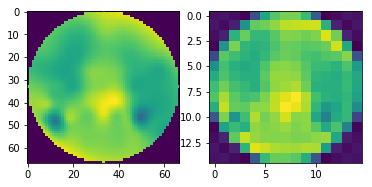

In [2]:
def group_frequency_bands(X):
    X_ = np.zeros([X.shape[0],X.shape[1],X.shape[2], 2])
#     X_[:,:,:,0] = np.mean(X[:,:,:,3:6],axis=3)
#     X_[:,:,:,1] = np.mean(X[:,:,:,7:11],axis=3)
#     X_[:,:,:,2] = np.mean(X[:,:,:,12:29],axis=3)
    
#     processing frequencies: 0 16
#     processing frequencies: 16 32
#     processing frequencies: 32 49
#     processing frequencies: 49 65
#     X_[:,:,:,0] = np.mean(X[:,:,:,0:16],axis=3)
#     X_[:,:,:,1] = np.mean(X[:,:,:,16:32],axis=3)
    X_[:,:,:,0] = np.mean(X[:,:,:,32:49],axis=3)
    X_[:,:,:,1] = np.mean(X[:,:,:,49:65],axis=3)
    
    X_.shape
    # subplot(1,3,1)
    # imagesc(squeeze(mean(X(1,:,:,4:7), 4)))
    # title('Theta')

    # subplot(1,3,2)
    # imagesc(squeeze(mean(X(1,:,:,8:12), 4)))
    # title('Alpha')

    # subplot(1,3,3)
    # imagesc(squeeze(mean(X(1,:,:,13:30), 4)))
    # title('Beta')
    return X_

def im_resize(X_, height, width):
    
    if width>0 and height>0:
        X__ = np.zeros([X_.shape[0], height, width, X_.shape[3]])
        for i in range(X_.shape[0]):
                for j in range(X_.shape[3]):
                    im = Image.fromarray(X_[i,:,:,j])
                    X__[i,:,:,j] = im.resize((height, width), Image.ANTIALIAS)
        print (X__.shape)

        plt.subplot(121)
        plt.imshow(np.array(X_[200,:,:,1]))
        plt.subplot(122)
        plt.imshow(np.array(X__[200,:,:,1]))
    else:
        print('IMAGES NOT RESIZED')
    return X__

def downsample_frequency_domain(n_bins):
    print('Downsampling the frequency domain from', X.shape[3],'to', n_bins)
    xx = np.zeros([X.shape[0],X.shape[1],X.shape[2],n_bins])
    print(xx.shape)
    a = np.round(np.linspace(0,X.shape[3],n_bins+1))
    a = a.astype('uint8')
    print(a)
    for i in range(n_bins):
        xx[:,:,:,i] = np.mean(X[:,:,:,a[i]:a[i+1]], axis=3)   
        print('processing frequencies:', a[i], a[i+1])
    print(xx.shape)
    return xx

def parse_array(in_array):
    new_array = []
    for i in range(len(in_array)):
        if str(in_array[i]).find("left")>0:
            new_array.append("left")
        if str(in_array[i]).find("right")>0:
            new_array.append("right")
        if (str(in_array[i]).find("left")<0 and 
            str(in_array[i]).find("right")<0):
            print(i)
            new_array.append("unknown")
    return new_array

def find_right(Q, label):
    idx = []
    for i in range(len(Q)):
        if Q[i] == label:
            idx.append(i)
    return(idx)


file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat' #0.77
# file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat' #2# #0.77
# file = 'Merged456-1-94_ICA(-2,3ICs)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat' #1# #0.76 #0.79
# file = 'EEG_ICA(-123_ICs)+proc_AUD_101_192_Merged456.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat'



# file = 'Merged123_1_64_ICA(-eyes)AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=1, TOPO, .mat'
# file = 'Merged123_75_134_ICA(-eyes)AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat'
# file = 'Merged123-143-202_ICA(-Eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat' #0.56

SHUFFLE = False
BATCH_SIZE = 20
TEST_TRAIN = 0.2
DS_FREQ = 1 #(0 1 2)
n_bins = 8
RESIZE = 1
width = 15
height = 15
SENSITIVITY = 0
knockouts = [0, 1, 2]

path = '/home/amplifier/home/DATASETS/' + file
mat_contents = sio.loadmat(path)
X = mat_contents['X']
Y = mat_contents['Z']
# Z = mat_contents['Z']
Q = parse_array(mat_contents['Q'])

if DS_FREQ==1:
    X = downsample_frequency_domain(n_bins)
    print('Downsampled Frequency Domain shape', X.shape)
if DS_FREQ==2:
    X = group_frequency_bands(X)
    print('Grouped Frequency Bands shape', X.shape)
if RESIZE==1:
    X = im_resize(X, height, width)
    print('Resized shape', X.shape)

if SENSITIVITY==1:
    X = np.delete(X, knockouts, axis=3)
    print('sens', X.shape)
if X.shape[1]<X.shape[2]:
    X = np.transpose(X,[0,2,1])

if Y.shape[1] > Y.shape[0]:
    Y = Y.T
    
# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
# Y = np.random.permutation(Y)

print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
x_train, x_test, y_train, y_test, q_train, q_test = train_test_split(X, Y, Q,
                                                                     test_size=TEST_TRAIN,
                                                                     shuffle=SHUFFLE,
                                                                     random_state=2)
print('Original data type:', x_train.dtype)


# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')
print('y_test.shape before', y_test.shape)


# one hot encode the labels:
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)
print('y_test.shape after', y_test.shape)

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

leng = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
chan = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

if len(X.shape)==3:
    streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
if len(X.shape)==4:
    streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1

Y = Y.flatten()
print('Prepped test input shape', x_test.shape, "Noralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('Prepped train input shape', x_train.shape, "Normalized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('Prepped test labels shape', y_test.shape, "Normalized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('Prepped train labels shape', y_train.shape, "Normalized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

# print('Window length', winsize)
# print('Step size:', stepsize)
# print('Trial length:', trial_len)

print('EEG in dataset:', X.shape)
print('Labels in dataset:', Y.shape)
print('Length of textual labels:', len(Q))

In [3]:
from itertools import product
from sys import getsizeof

    
def get_pairs(X,Y):
    print('X', X.shape)
    print('Y', Y.shape)
    
    # get the full permutation (very LARGE DATASET!)

    temp = []
    for x in product(range(Y.shape[0]), repeat=2):
        temp.append(np.array(x))
    
    n_perm = len(temp)
    temp = np.array(temp)
    print('temp', temp.shape)

    XX = np.zeros([n_perm,2,15,15,8])
    XX[:,0,:,:,:] = X[[temp[i,0] for i in range(n_perm)],:,:,:]
    XX[:,1,:,:,:] = X[[temp[i,1] for i in range(n_perm)],:,:,:]

    print('Data size in memory (GB):', np.round(getsizeof(XX)/1024/1024/1024, 2))

    YY = np.zeros([n_perm, 2])
    YY[:,0] = Y[[temp[i,0] for i in range(n_perm)]].flatten()
    YY[:,1] = Y[[temp[i,1] for i in range(n_perm)]].flatten()

    YYY = []
    for i in range(len(YY)):
        YYY.append(0 if YY[i,0]==YY[i,1] else 1)
    YYY = np.array(YYY).flatten()
    
    # diag:
#     print (XX.shape, YYY.shape)
#     for i in range(XX.shape[0]):
#         print(temp[i,0], YY[i,0], temp[i,1], YY[i,1], YYY[i])

    print('Left Col', np.mean(YY[:,0]))
    print('Right Col', np.mean(YY[:,1]))
    print('Labels', np.mean(YYY), '\n')
    
    print("\nPairs", XX.shape)
    print("Labels", YYY.shape)
    
    return XX, YYY

In [4]:
X_test, Y_test = get_pairs(x_test, y_test[:,0])
X_train, Y_train = get_pairs(x_train, y_train[:,0])

X (90, 15, 15, 8)
Y (90,)
temp (8100, 2)
Data size in memory (GB): 0.22
Left Col 0.5
Right Col 0.5
Labels 0.5 


Pairs (8100, 2, 15, 15, 8)
Labels (8100,)
X (360, 15, 15, 8)
Y (360,)
temp (129600, 2)
Data size in memory (GB): 3.48
Left Col 0.5
Right Col 0.5
Labels 0.5 


Pairs (129600, 2, 15, 15, 8)
Labels (129600,)


In [5]:
def Model_my(sh, outp):
    dilation_rate = 1

    def activation():
        return ELU(alpha=1.0) # Activation('relu') #

    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, ELU
    from keras.models import Model
    from keras.callbacks import TensorBoard, EarlyStopping
    from keras.optimizers import Adam

    input_img = Input(shape=sh)  # adapt this if using `channels_first` image data format

    x = Conv2D(30, (3, 3), activation='relu', padding='same', dilation_rate=dilation_rate)(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(30, (3, 3), activation='relu', padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(60, (3, 3), activation='relu', padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Conv2D(60, (3, 3), activation='relu', padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(120, (2, 2), activation='relu', padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(outp, activation='softmax')(x)

    model = Model(input_img, x)
    return model

In [6]:
from keras.engine.topology import Layer
from keras.layers import Concatenate

# def triplet_loss(y_true, y_pred):
#     norm1 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[1]), axis=-1, keepdims=True))
#     norm2 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[2]), axis=-1, keepdims=True))
#     loss = norm1 - norm2 + 0.2
#     return loss

input_shape = X_train[0][-1,:,:].shape
input_shape

# input_shape = xx_train[0][0].shape + (1,)
a_input = Input(input_shape)
r_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
# encoded NOT as Sequential (stack of layers), but as a Tensor!!!! if you add an argument, a Tensor is returned
encoded_a = Model_my(input_shape, 6)(a_input)
encoded_r = Model_my(input_shape, 6)(r_input)

L1_distance = Lambda(lambda tensors: (K.abs(tensors[0] - tensors[1])))([encoded_a, encoded_r])
L1_distance = Dense(1,activation='sigmoid', use_bias=True)(L1_distance)

# siamese_net = Model(inputs=[a_input, r_input], outputs=[encoded_a, encoded_r, L1_distance])
siamese_net = Model(inputs=[a_input, r_input], outputs=[L1_distance])
optimizer = Adam(0.00006)
# optimizer = 'adam'
# siamese_net.compile(loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'], optimizer=optimizer)
siamese_net.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
siamese_net.summary()

a1 = np.linalg.norm(siamese_net.layers[2].layers[21].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[21].get_weights()[0])
print(a1, a2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 15, 8)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15, 15, 8)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 6)            138776      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 6)            138776      input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_acc', patience=20, mode='min')
checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/Siam3topo_wts.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)

train_history = siamese_net.fit([X_train[:,0,:,:,:], X_train[:,1,:,:,:]], Y_train,
                epochs=1000,
                batch_size=100,
                verbose=1,
                shuffle=True,
                validation_data=([X_test[:,0,:,:], X_test[:,1,:,:]], Y_test),
                callbacks=[checkpointer, early_stopping])

# siamese_net.load_weights('/home/amplifier/home/NEW_DL/weights/Siam3_wts.h5')

Train on 129600 samples, validate on 8100 samples
Epoch 1/1000
129600/129600 [==============================] - 42s 323us/step - loss: 0.6950 - acc: 0.5003 - val_loss: 0.6937 - val_acc: 0.4952

Epoch 00004: val_acc did not improve from 0.50642
Epoch 5/1000
129600/129600 [==============================] - 42s 321us/step - loss: 0.6946 - acc: 0.5003 - val_loss: 0.6945 - val_acc: 0.4974

Epoch 00005: val_acc did not improve from 0.50642
Epoch 6/1000
129600/129600 [==============================] - 42s 321us/step - loss: 0.6946 - acc: 0.4995 - val_loss: 0.6938 - val_acc: 0.5019

Epoch 00006: val_acc did not improve from 0.50642
Epoch 7/1000
129600/129600 [==============================] - 41s 320us/step - loss: 0.6941 - acc: 0.5015 - val_loss: 0.6934 - val_acc: 0.5063

Epoch 00007: val_acc did not improve from 0.50642
Epoch 8/1000
129600/129600 [==============================] - 42s 321us/step - loss: 0.6941 - acc: 0.5016 - val_loss: 0.6935 - val_acc: 0.5037

Epoch 00008: val_acc did not i

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



129600/129600 [==============================] - 42s 320us/step - loss: 0.4181 - acc: 0.9988 - val_loss: 0.6597 - val_acc: 0.6316

Epoch 00015: val_acc did not improve from 0.64333
Epoch 16/1000
129600/129600 [==============================] - 42s 320us/step - loss: 0.3843 - acc: 0.9998 - val_loss: 0.6589 - val_acc: 0.6389

Epoch 00016: val_acc did not improve from 0.64333
Epoch 17/1000
129600/129600 [==============================] - 42s 322us/step - loss: 0.3568 - acc: 1.0000 - val_loss: 0.6605 - val_acc: 0.6438

Epoch 00017: val_acc improved from 0.64333 to 0.64383, saving model to /home/amplifier/home/NEW_DL/weights/Siam3topo_wts.h5
Epoch 18/1000
129600/129600 [==============================] - 42s 321us/step - loss: 0.3324 - acc: 1.0000 - val_loss: 0.6708 - val_acc: 0.6379

Epoch 00018: val_acc did not improve from 0.64383
Epoch 19/1000
125700/129600 [============================>.] - ETA: 1s - loss: 0.3109 - acc: 0.9998

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



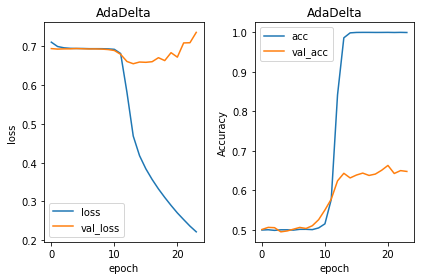

In [8]:
# print(np.array(history.losses))
import matplotlib.pyplot as plt
%matplotlib inline
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.subplot(121)
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')

acc = train_history.history['acc']
val_acc = train_history.history['val_acc']

plt.subplot(122)
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc', 'val_acc'])
plt.title('AdaDelta')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.tight_layout()